<a href="https://colab.research.google.com/github/Rayryu/Should-I-read-this-hespress-article/blob/master/Should_I_read_this_Hespress_article.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up environment and imports

In [20]:
!pip install selenium

In [0]:
import sys
from selenium import webdriver
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

In [0]:
# For reproducibility
seed = random.seed()

# Scraping data from one article

## Robot.txt

Hespress's robot.txt file allows crawling any url ending with .html with is perfect for this project since we are only extraction articles data. 


```
User-agent: Alexabot
Disallow:

User-agent: *
Disallow: /*?print$
Disallow: /*/abuse.php
Disallow: /abuse.php
Disallow: /mobile/abuse.php
Disallow: /*/mobile/abuse.php
```



## Running a chromdriver

We're setting up a chromiumdriver in colab.

In [23]:
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 88.7 kB in 2s (49.0 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree     

Here Selenium opens the chrome driver wihtout opening a new window.

In [0]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome("chromedriver", options=chrome_options)

## Extracting data 

The get() method will make the driver navigate to the given URL, and **wait** until the page is fully loaded! (unlike request library)

In [0]:
URL = "https://www.hespress.com/societe/469822.html"

driver.get(URL)

The HTML page is fully loaded now, and we can access it's content using driver's methods.

Article's title

In [0]:
title_element = driver.find_elements_by_xpath("//h1[@class='page_title']")  
title = title_element[0].text

In [28]:
print(title)

وزارة التربية تنفي "قرار السبت" وتطالب باستئناف الدراسة عن بُعد


Article's body

In [0]:
body_element = driver.find_element_by_xpath("//div[@id='article_body']") 
body = body_element.text

In [30]:
print(body)

هسبريس - نورالدين إكجان
السبت 02 ماي 2020 - 14:00
منهكة من تتبع تناسل صفحات وأخبار زائفة، جددت وزارة التربية الوطنية نفيها لحسابات إلكترونية باسم سعيد أمزازي، تشهد تعاليق كثيفة من تلاميذ وطلبة، يتفاعل معها صاحب الحساب بشكل غير لائق أحيانا، ما حتم الخروج لنفي صلة الوزير بها.
وعلى امتداد الأسبوع الجاري، تناقلت العديد من الصفحات إمكانية الإفراج عن خبر استثنائي اليوم السبت، يتعلق أساسا بمستقبل السنة الدراسية، وهو ما تنفيه الوزارة جملة وتفصيلا، مطالبة المتعلمين بالانكباب على التحصيل الدراسي.
ومنذ بداية فترة "الحجر الصحي"، خرجت وزارة التربية الوطنية لنفي صحة أخبار تتعلق بقرار سنة بيضاء أو إنجاح جميع التلاميذ أو توقيف الدراسة إلى غاية إشعار آخر، وهو ما أربك عمل الوزارة على امتداد فترة اعتماد "التعليم عن بعد".
وإلى جانب الحسابات والصفحات المزورة، اشتكت الوزارة من اختراق الموقع الرسمي لقطاع التعليم العالي، وهو ما دفعها إلى الاستعانة بالسلطات المختصة من أجل التحري بخصوص الموضوع، وجر المسؤولين عن ذلك إلى القضاء.
وحسب مصادر مسؤولة من داخل وزارة التربية الوطنية، فلا وجود نهائيا لقرار سيتخذ اليوم ال

we need to remove the first wo lines (author and date)

In [0]:
body_splitted = body.split("\n")
author = body_splitted[0].split("-")[1]
date = body_splitted[1]
body = "".join(body.split("\n")[2:])

In [32]:
print(author)

 نورالدين إكجان


In [33]:
print(date)

السبت 02 ماي 2020 - 14:00


Comments and votes

In [0]:
comments_list_element = driver.find_elements_by_class_name("comment_text") 

In [0]:
comments = [comment.text for comment in comments_list_element]

In [0]:
votes_list_element = driver.find_elements_by_class_name("result") 

In [0]:
votes = [vote.text for vote in votes_list_element]

## Building a dataframe

In [0]:
data = pd.DataFrame(data={"comment":comments, "vote": votes})
data["author"] = author
data["title"] = title
data["text"] = body
data["date"] = date
data = data[['author', 'title', 'text', 'comment', 'vote','date']]

In [39]:
data.head()

,author,title,text,comment,vote,date
0,نورالدين إكجان,"وزارة التربية تنفي ""قرار السبت"" وتطالب باستئنا...",منهكة من تتبع تناسل صفحات وأخبار زائفة، جددت و...,تاحنا ماشي شغلنا ماعمرهوم مايديرو شي حاجة كاتف...,574,السبت 02 ماي 2020 - 14:00
1,نورالدين إكجان,"وزارة التربية تنفي ""قرار السبت"" وتطالب باستئنا...",منهكة من تتبع تناسل صفحات وأخبار زائفة، جددت و...,الله يرحم الوالدين اعطيونا شي خبر يقين باش نعر...,1012,السبت 02 ماي 2020 - 14:00
2,نورالدين إكجان,"وزارة التربية تنفي ""قرار السبت"" وتطالب باستئنا...",منهكة من تتبع تناسل صفحات وأخبار زائفة، جددت و...,كتلميذ مغربي لا يمكننا مواصلة هكذا دون معرفة م...,479,السبت 02 ماي 2020 - 14:00
3,نورالدين إكجان,"وزارة التربية تنفي ""قرار السبت"" وتطالب باستئنا...",منهكة من تتبع تناسل صفحات وأخبار زائفة، جددت و...,الدراسة عن بعد لاحول ولا قوة الابالله. الناس م...,606,السبت 02 ماي 2020 - 14:00
4,نورالدين إكجان,"وزارة التربية تنفي ""قرار السبت"" وتطالب باستئنا...",منهكة من تتبع تناسل صفحات وأخبار زائفة، جددت و...,صفحة الوزير لي فيها التعليقات راها موثقة ببطاق...,211,السبت 02 ماي 2020 - 14:00


We can extract more features from the HTML page (like comment's date, article image...) but we will restrict ourselves to the 6 attributes that we have chosen.

## Wrapping up everything


We want to write a function that takes in parameters an article's URL and returns a Pandas DataFrame with its content.

In [0]:
import sys
from selenium import webdriver
import pandas as pd
import time

def extract_data(url: str) -> pd.DataFrame:
    """Navigate to the giving URL and extract data from it's content.

    Parameters:
    url (string): article's url.

    Returns:
    pd.DataFrame: a Panda's DataFrame containing article's data.

    """
    # Setting up environnement and creating a driver object
    sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome("chromedriver", options=chrome_options)
    time.sleep(1)

    # Navigate to the given URL, and wait until the page is fully loaded!
    driver.get(url)
    time.sleep(5)

    # Extracting fields
    title_element = driver.find_elements_by_xpath("//h1[@class='page_title']")  
    title = title_element[0].text

    time.sleep(2)
    body_element = driver.find_elements_by_id("article_body") 
    body = body_element[0].text if len(body_element)>0 else ""
    body_splitted = body.split("\n") 
    author = body_splitted[0].split("-")[1] if "-" in body_splitted[0] else body_splitted[0]
    date = body_splitted[1]
    body = "".join(body.split("\n")[2:])

    
    comments_list_element = driver.find_elements_by_class_name("comment_text") 
    comments = [comment.text for comment in comments_list_element]
    
    votes_list_element = driver.find_elements_by_class_name("result") 
    votes = [vote.text for vote in votes_list_element]

    # Building a Pandas Dataframe 
    data = pd.DataFrame(data={"comment":comments, "vote": votes})
    data["author"] = author
    data["title"] = title
    data["text"] = body
    data["date"] = date
    data = data[['author', 'title', 'text', 'comment', 'vote','date']]

    return data

In [41]:
URL = "https://www.hespress.com/societe/469866.html"
data = extract_data(URL)
data.head()

,author,title,text,comment,vote,date
0,هسبريس من الرباط,جمعية توضح سياق صرف منح لموظفين بالسجن,"ردا على ما جرى تداوله، مؤخرا، بخصوص ""صرف منحة ...",شكرا للجمعية على المبادرة على كل حال. اما مندو...,17,السبت 02 ماي 2020 - 19:35
1,هسبريس من الرباط,جمعية توضح سياق صرف منح لموظفين بالسجن,"ردا على ما جرى تداوله، مؤخرا، بخصوص ""صرف منحة ...",أتعجب لما إدارة من المؤسسات المغربية او جمعية ...,11,السبت 02 ماي 2020 - 19:35
2,هسبريس من الرباط,جمعية توضح سياق صرف منح لموظفين بالسجن,"ردا على ما جرى تداوله، مؤخرا، بخصوص ""صرف منحة ...",نتق في جمعية التكافل وننوه بكل ما تقوم به في س...,10,السبت 02 ماي 2020 - 19:35
3,هسبريس من الرباط,جمعية توضح سياق صرف منح لموظفين بالسجن,"ردا على ما جرى تداوله، مؤخرا، بخصوص ""صرف منحة ...",اعلان فالمغرب ماكاين اش خدمة مضبوطة(اكاديمية)....,2,السبت 02 ماي 2020 - 19:35
4,هسبريس من الرباط,جمعية توضح سياق صرف منح لموظفين بالسجن,"ردا على ما جرى تداوله، مؤخرا، بخصوص ""صرف منحة ...",الطابع شبه العسكري للقطاع والاعباء الجسيمة الم...,14,السبت 02 ماي 2020 - 19:35


# Reading dataset

In [0]:
data = pd.read_excel("ElecMorocco2016.xlsx")
data = data[["comment_message", "sentiment"]]
data.columns = ["comment", "label"]

In [43]:
data.shape

(10254, 2)

In [44]:
data.head(20)

,comment,label
0,البكاء ليس سمت الرجال ..البكاء سلطة الضعفاء لك...,N
1,كلنا بنكيران\nولاية ثانية ان شاء الله\nموتوا ب...,P
2,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,N
3,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,N
4,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,N
5,في نظرك الحكومات السابقة كانت احسن اتقوا الله ...,P
6,رئيس الحكومة يمر بتجربة صعبة للغاية فرغم كل ال...,P
7,Zakaria Sam هل مستوى االعيش في بلادنا مثل فرنس...,N
8,احسن حكومة في المغرب ساصوت على العدالة والتنمي...,P
9,المنافقين هما البام لي مزال معرفتهم أش كيسواو ...,N


In [45]:
data.isna().sum()

comment    0
label      0
dtype: int64

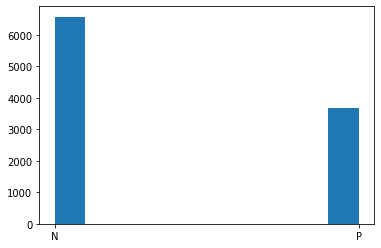

In [46]:
_ = plt.hist(data.label)

# Building a baseline model

## Data preprocessing

### Cleaning data

In [0]:
def clean_text(text):
    # Replace latin words with spaces
    text = re.sub(r'[A-z]+', " ", text)
    
    # Replace punctuation characters with spaces
    filters='!"#$%&()*+,-./:;<=>?؟@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    # Remove double spaces
    text = re.sub(r"  ", " ", text)

    return text

In [0]:
data.comment = data.comment.map(lambda x: clean_text(x))

### Formating labels

In [0]:
data.label = data.label.map(lambda x:0 if x=="N" else 1)

In [50]:
data.head(25)

,comment,label
0,البكاء ليس سمت الرجال البكاء سلطة الضعفاء لكس...,0
1,كلنا بنكيران ولاية ثانية ان شاء الله موتوا بحقدكم,1
2,الشركات في الدول المتقدمة تساهم في بناء أوطانه...,0
3,من ينتقد بن كران هم خصوم معارضة لى خاصها هي سل...,0
4,هدو صحاب بام توجدو راسهوم بغين اعفاءات ضريبية ...,0
5,في نظرك الحكومات السابقة كانت احسن اتقوا الله ...,1
6,رئيس الحكومة يمر بتجربة صعبة للغاية فرغم كل ال...,1
7,هل مستوى االعيش في بلادنا مثل فرنسا يونان اس...,0
8,احسن حكومة في المغرب ساصوت على العدالة والتنمي...,1
9,المنافقين هما البام لي مزال معرفتهم أش كيسواو ...,0


## Training

Spliting train data into training and validation sets.

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data.comment, data.label, stratify=data.label, random_state=seed, test_size=0.2, shuffle=True)

In [0]:
def rmse(true_labels: list, predicted_labels: list)->float:

    return np.sqrt(mse(true_labels, predicted_labels)/len(true_labels))

### TF-IDF -> Logistic Regression

First we need to create a TF-IDF vectoirzer object. We'll be using a custom stop-words that we've found in this [repository](https://github.com/mohataher/arabic-stop-words/blob/master/list.txt).

In [0]:
arabic_stop_words = [word[:-1] for word in open("list.txt", "r")]

In [0]:
tfv = TfidfVectorizer(min_df=3, analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words = arabic_stop_words)

In [55]:
# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_valid))
X_train_tfv =  tfv.transform(X_train) 
X_valid_tfv = tfv.transform(X_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'آها', 'أب', 'أخ', 'أف', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إليك', 'إليكن', 'إم', 'إيه', 'ات', 'اتان', 'ارتد', 'انفك', 'بخ', 'برح', 'بس', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'ذان', 'سيما', 'شتان', 'صه', 'ظن', 'عد', 'قط', 'كأي', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هاك', 'هب', 'واها', 'وراء'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Then we'll be running a simple Logistic Regression classifier

In [56]:
model = LogisticRegression(C=1, penalty='l2')
model.fit(X_train_tfv, y_train)

model.score(X_train_tfv, y_train) # score = 1 - mse

0.8584664147263197

In [57]:
model.score(X_valid_tfv, y_valid)

0.7859580692345197

## Predict

Let's predict!

In [81]:
URL = "https://www.hespress.com/sciences-nature/467266.html"
data = extract_data(URL)
data.head()

,author,title,text,comment,vote,date
0,هسبريس من الرباط,شركة مغربية تصمم نفق تعقيم من فيروس كورونا,"كشفت مجموعة ""جيت كونتراكتورز"" المغربية عن ابتك...",هذا النفق المعقم يجب أن يوضع أمام المستشفيات و...,95,الأحد 12 أبريل 2020 - 11:55
1,هسبريس من الرباط,شركة مغربية تصمم نفق تعقيم من فيروس كورونا,"كشفت مجموعة ""جيت كونتراكتورز"" المغربية عن ابتك...",نسمع عن إبتكارات و لا نسمع عن براءات إختراع ! ...,57,الأحد 12 أبريل 2020 - 11:55
2,هسبريس من الرباط,شركة مغربية تصمم نفق تعقيم من فيروس كورونا,"كشفت مجموعة ""جيت كونتراكتورز"" المغربية عن ابتك...",صباح الخير\nبرافو ،\nعمتم صباحا,22,الأحد 12 أبريل 2020 - 11:55
3,هسبريس من الرباط,شركة مغربية تصمم نفق تعقيم من فيروس كورونا,"كشفت مجموعة ""جيت كونتراكتورز"" المغربية عن ابتك...",ماشاء الله تبارك الله عندنا طاقات وابداع البلا...,36,الأحد 12 أبريل 2020 - 11:55
4,هسبريس من الرباط,شركة مغربية تصمم نفق تعقيم من فيروس كورونا,"كشفت مجموعة ""جيت كونتراكتورز"" المغربية عن ابتك...",فكرة جيد يمك استخدامها عند مداخل المستشفيات و ...,24,الأحد 12 أبريل 2020 - 11:55


In [0]:
comments = data.comment
cleaned_comments = comments.map(lambda x: clean_text(x))
comments_tfv = tfv.transform(cleaned_comments)

In [0]:
predictions = model.predict(comments_tfv)
predictions_df = pd.DataFrame({"comment":comments, "label":predictions})
pd.options.display.max_colwidth = 200
predictions_df.head(25)

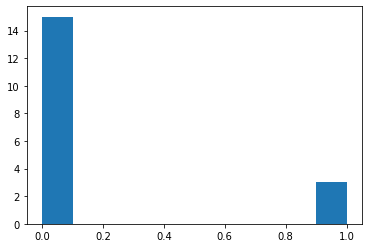

In [84]:
_ = plt.hist(predictions)

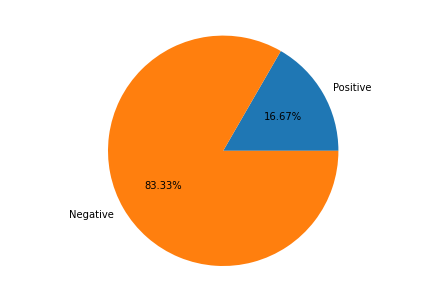

In [85]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
sentiments = ['Positive', 'Negative']
pourcentages = [sum(predictions==1)*100/len(predictions),100-sum(predictions==1)*100/len(predictions)]
ax.pie(pourcentages, labels = sentiments,autopct='%1.2f%%')
plt.show()

# Testing some classifiers

In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

names = ["Logistic Regression", 
         #"Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         #"Naive Bayes", "QDA"
         "XGboost"]

classifiers = [
    LogisticRegression(),
    #KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
    XGBClassifier()
    ]

for name, clf in zip(names, classifiers):
    print(name)
    if name in ["Gaussian Process"]:
        clf.fit(X_train_tfv.toarray(), y_train)
        score = clf.score(X_valid_tfv.toarray(), y_valid)
    else:
        clf.fit(X_train_tfv, y_train)
        score = clf.score(X_valid_tfv, y_valid)

    print(name + ": " + str(score))

Logistic Regression
Logistic Regression: 0.7859580692345197
Nearest Neighbors
Nearest Neighbors: 0.4144319843978547
Linear SVM
Linear SVM: 0.6674792784007801
RBF SVM
RBF SVM: 0.7610921501706485
Decision Tree
Decision Tree: 0.7055095075572891
Random Forest
Random Forest: 0.6416382252559727
Neural Net
Neural Net: 0.6509019990248659
AdaBoost
AdaBoost: 0.7518283764017553
XGboost
XGboost: 0.7401267674305217


In [62]:
estimator = XGBClassifier(objective= 'binary:logistic', nthread=-1, seed=seed)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True
)
grid_search.fit(X_train_tfv, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 29.3min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
     

In [78]:
grid_search.best_score_

0.801677955401751

In [79]:
grid_search.score(X_train_tfv, y_train)

0.9294971351585828

In [80]:
grid_search.score(X_valid_tfv, y_valid)

0.8026332113392469